In [83]:
from data import BaostockDataWorker, DATABASE
DATABASE_PATH = os.getcwd()     # 解决方法
print("----database:"+DATABASE_PATH +"/"+ DATABASE + "----")
dw = BaostockDataWorker()


ImportError: cannot import name 'OCLHVA' from 'globals' (/Users/yin/Library/CloudStorage/OneDrive-Personal/2.doing/bandwagon/globals.py)

In [73]:
# t = dw.all_tickers[dw.all_tickers.type == 1 & dw.all_tickers.status == 1].sample(1).iloc[0].code
t = dw.all_tickers
t

NameError: name 'dw' is not defined

In [5]:
import baostock as bs
import os
import sqlite3
import pandas as pd
from functools import partial
from globals import MAIN_PATH, OLHCVA, MKT_OCLHVA, BAOSTOCK_MAPPING
import pysnooper
from datetime import datetime, timedelta
from itertools import count
import tushare as ts


class DataWorker(object):
    def __init__(self) -> None:
        self.ds = DataStorage()
        self.begin = "2000-01-01"

    def __del__(self) -> None:
        pass
    
    @property
    def all_tickers(self) -> pd.DataFrame :
        pass
    
    def minute(self,ticker,ktype='1') -> pd.DataFrame :
        pass

    def save(self, rs:pd.DataFrame) -> bool:
        pass

class BaostockDataWorker(DataWorker):
    def __init__(self) -> None:
        super().__init__()
        self.login = bs.login(user_id="anonymous", password="123456")
        self.ds = DataStorage()
        self.begin = "2000-01-01"

    @property
    def all_tickers(self) -> pd.DataFrame :
        tickers = bs.query_stock_basic().get_data()  # 获取最新证券基本资料，可以通过参数设置获取对应证券代码、证券名称的数据
        self.ds.save_tickers(tickers)
        return tickers

    # @pysnooper.snoop()
    def minute(self,ticker,start_date, end_date, ktype='5') -> pd.DataFrame :
        ''' download 5-minutely data if ticker available
        http://baostock.com/baostock/index.php/Python_API文档
        '''
        end_date = datetime.today if end_date is None else end_date
        rs = bs.query_history_k_data_plus(ticker, "date,time,code,open,high,low,close,volume,amount,adjustflag",
            start_date = start_date, end_date = end_date, frequency = ktype, adjustflag="2")
        self.stock = rs.get_data() # if rs.error_code == '0' else None
        self.stock[OLHCVA] = self.stock[OLHCVA].astype('float')  # Baostock给出的是object，不是float的要转成float
        self.stock.rename(columns = BAOSTOCK_MAPPING,inplace = True) 
        return self.stock

    def market(self,ticker) -> str:
        ''' returns the market index of designated ticker. 
        注意指数没有分钟线数据... ...怎么办？
        ie. 'sh.000023' goes to 'sh.000001' # 上证综指 
            'sz.300333' goes to 'sz.300001' # 深圳综指
            'hk.00700' goes to 'HSI'        # 恒生指数
            'us.######' goes to 'NASDAQ' or 'DJX' 
        '''
        market = ticker.split(".")[0]
        # match market:   # requires python 3.10 or higher version
        #     case 'sh': 'sh.000001'
        #     case 'sz':  'sz.000001'
        #     case 'hk':  'HSI'
        #     case 'us':  'DJX'
        if market == 'sh':
            mkt = 'sh.000001'
        elif market == 'sz':
            mkt = 'sz.300006'
        elif market == 'hk':
            mkt = 'HSI'
        else:
            print("invalid market label")
        return mkt # 暂时以上证指数为大盘

    def minute_mkt(self,ticker,ktype='5') -> pd.DataFrame:
        ''' downloads 5-min with market data if ticker available
        常用的合并方法包括append、assign、combine、update、concat、merge、join等
        '''
        rs1 = self.minute(ticker, ktype)
        mkt = self.market(ticker)
        begin = rs1.date.min
        end = rs1.date.max
        rs2 = self.minute(mkt, begin, end, ktype = 'd') # only ktype = 'd' is available for indices in Baostock
        rs2.rename(columns=dict(zip(OLHCVA, MKT_OCLHVA)),inplace = True) 
        rs2.rename(columns={'code':"mkt_code"},inplace = True) 
        return rs2 # returns rs2 only
        # return rs1.merge(rs2,how='left', left_on=["date","time"],right_on=["date","time"])  # 按列合并
    
    def save(self, rs:pd.DataFrame) -> bool:
        return self.ds.save_raw(rs)

ImportError: cannot import name 'OLHCVA' from 'globals' (/Users/yin/Library/CloudStorage/OneDrive-Personal/2.doing/bandwagon/globals.py)

In [72]:
rs = dw.minute(t0)
rs

NameError: name 'dw' is not defined

In [6]:
rs

NameError: name 'rs' is not defined

In [163]:
from globals import OLHCVA, Infinitesimal

In [164]:
import numpy as np
# from utils import sigmoid_plus
# tanh = lambda z:(np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
def tanh(z):
    return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))


sigmoid_ = lambda x: 1.0/(1+np.exp(-x)) - 0.5

rs[rs.volume == 0] = Infinitesimal
rs[rs.amount == 0] = Infinitesimal

In [165]:
rs_ = rs[OLHCVA].pct_change().dropna()

In [166]:
rs_.describe()

,open,low,high,close,volume,amount
count,2.486890e+05,2.486890e+05,2.486890e+05,2.486890e+05,2.486890e+05,2.486890e+05
mean,4.021602e+14,4.017163e+14,4.025338e+14,4.020905e+14,1.424009e+18,1.011940e+19
std,3.993607e+15,3.989390e+15,3.997254e+15,3.992994e+15,8.022747e+19,5.795624e+20
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.275615e+00
25%,-1.283697e-03,-1.040583e-03,-1.112347e-03,-1.275510e-03,-4.472097e-01,-4.472844e-01
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.783690e-04
75%,1.213592e-03,1.068376e-03,1.015228e-03,1.226994e-03,7.966457e-01,7.965732e-01
max,7.680356e+16,7.680356e+16,7.695982e+16,7.695982e+16,2.113900e+22,1.374529e+23


In [120]:
rs_[['volume','amount']] = rs_[['volume','amount']].applymap(sigmoid_)

ValueError: Maximum allowed size exceeded

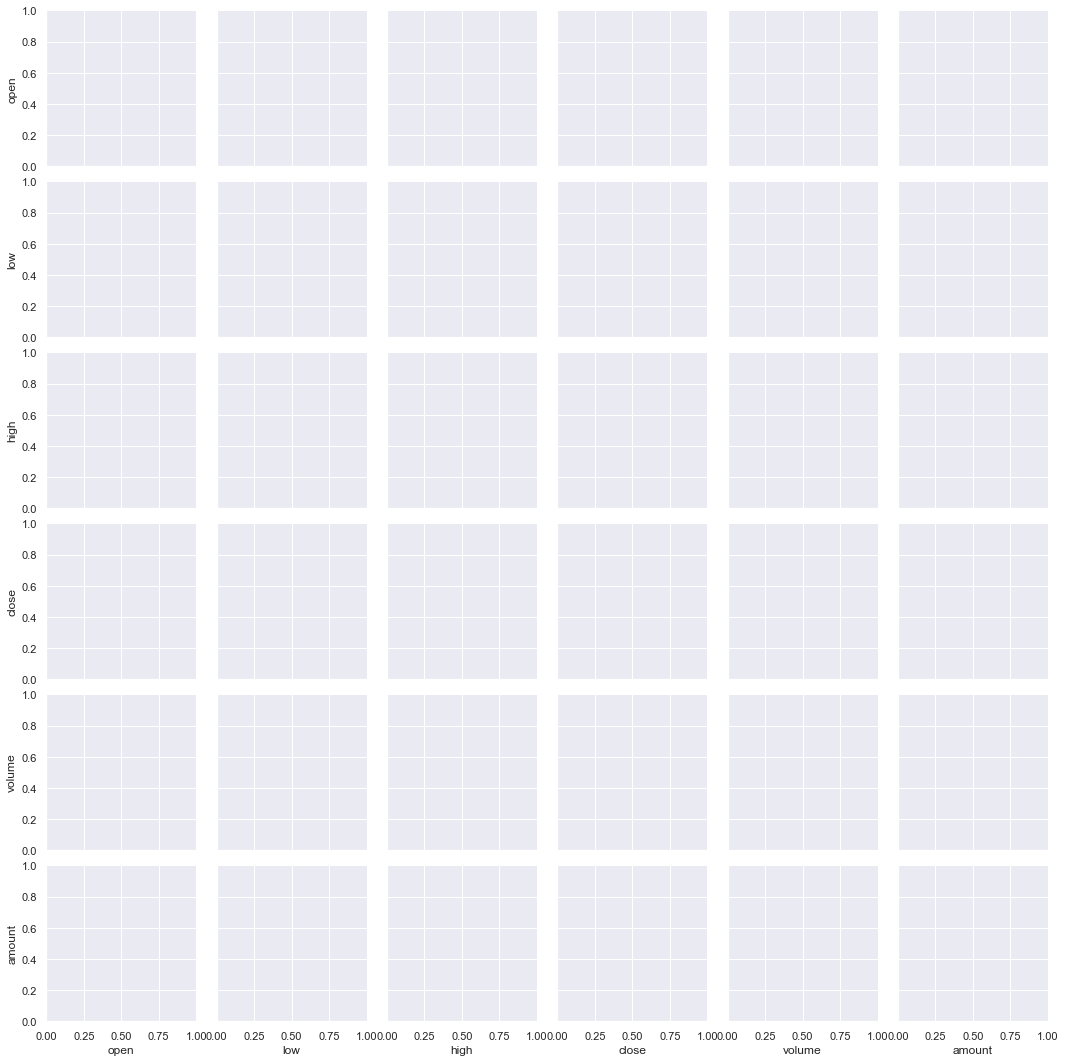

In [289]:
sns.pairplot(rs_)

In [156]:
import seaborn as sns
sns.factorplot(rs_.sample(100))

/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'kind', 'col', 'size', 'style', 'facet_kws'
  


,align,choice,time,coherence,firing_rate
0,dots,T1,-80,0.0,33.189967
1,dots,T1,-80,3.2,31.691726
2,dots,T1,-80,6.4,34.279840
3,dots,T1,-80,12.8,32.631874
4,dots,T1,-80,25.6,35.060487
...,...,...,...,...,...
843,sacc,T2,300,3.2,33.281734
844,sacc,T2,300,6.4,27.583979
845,sacc,T2,300,12.8,28.511530
846,sacc,T2,300,25.6,27.009804


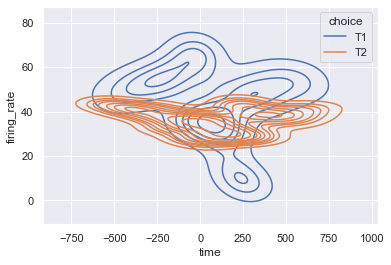

In [160]:
dots = sns.load_dataset("dots")
sns.kdeplot(
    data=dots, kind="line",
    x="time", y="firing_rate", col="align",
    hue="choice", size="coherence", style="choice",
    facet_kws=dict(sharex=False),
)

dots

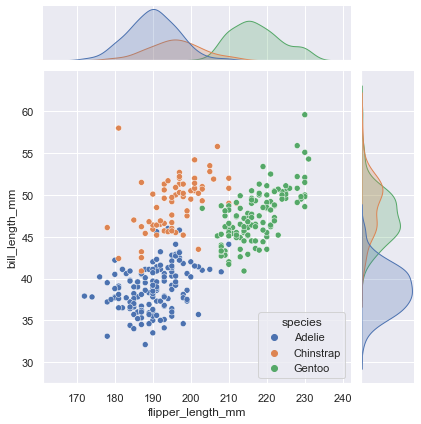

In [150]:
from unicodedata import category
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
penguins = sns.load_dataset("penguins")
sns.jointplot(data=penguins, x="flipper_length_mm", y="bill_length_mm", hue="species")

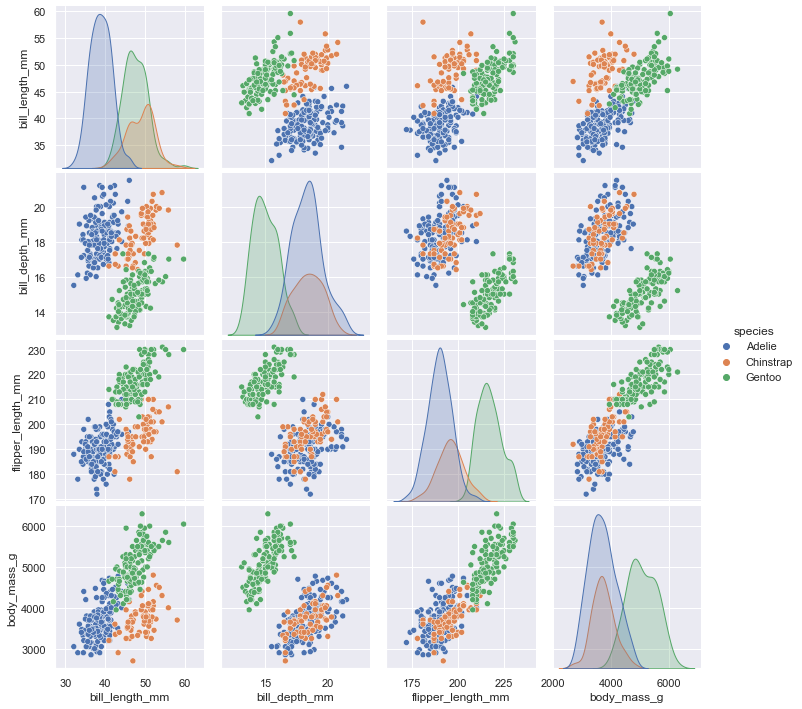

In [290]:
sns.pairplot(data=penguins, hue="species")

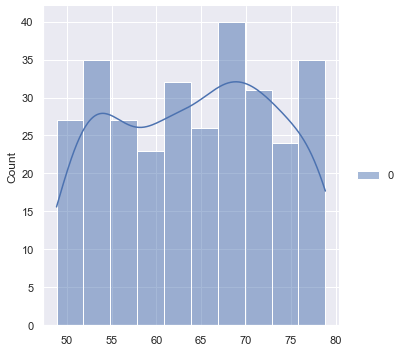

In [193]:
pt = PowerTransformer(method='box-cox', standardize=False)
X_pt = pt.fit_transform(X)                   
sns.displot(X_pt, kde=True)

In [262]:
df = pd.DataFrame({'A':np.array([1,np.nan,2,3,6,np.nan]),
                 'B':np.array([np.nan,4,np.nan,5,9,np.nan]),
                  'C':'foo'})
df.isna()                  

,A,B,C
0,False,True,False
1,True,False,False
2,False,True,False
3,False,False,False
4,False,False,False
5,True,True,False


In [291]:
x = np.array([0,1,3])
y = np.array([0,1,5])
a1=len(x)*((x*y).sum())-x.sum()*y.sum()
a2=len(x)*((x**2).sum())-(x.sum())**2
a=a1/a2
b=y.mean()-a*(x.mean())
print(a,b)

1.7142857142857142 -0.2857142857142856


In [474]:
# 第二种解法： a = np.cov(x,y)/ x.var(), b = (y - a*x).mean() 
a = ((x*y).mean() - x.mean()*y.mean())/x.var()
b = (y - a*x).mean() 
print(a,b)


covar = lambda x,y: ((x*y).mean() - x.mean()*y.mean())

covar(x,y)/covar(x,x)

1.7142857142857142 -0.28571428571428553


1.714285714285714

In [490]:
# 用np.cov(), np.var() 要注意是总体还是样本，总体的时候分母是n，样本时分母是n-1
np.cov(x,y)[1,0]*2/3 , covar(x,y)
covar(x,x) , x.var()


(1.5555555555555558, 1.5555555555555556)

In [348]:
#首先我们先建立一个数据集，这也是之后用来训练和测试的数据
#导入包，创建数据集
import pandas as pd
examDict={
    '学习时间':[0.50,0.75,1.00,1.25,1.50,1.75,1.75,2.00,2.25,
            2.50,2.75,3.00,3.25,3.50,4.00,4.25,4.50,4.75,5.00,5.50],
    '分数':    [10,  22,  13,  43,  20,  22,  33,  50,  62,  
              48,  55,  75,  62,  73,  81,  76,  64,  82,  90,  93]
}
exam=pd.DataFrame(examDict)
#看看数据集长什么样
exam.head()

,学习时间,分数
0,0.50,10
1,0.75,22
2,1.00,13
3,1.25,43
4,1.50,20


In [6]:
import numpy as np

### EM算法过程函数定义
def em(data, thetas, max_iter=30, eps=1e-3):
    '''
    输入：
    data：观测数据
    thetas：初始化的估计参数值
    max_iter：最大迭代次数
    eps：收敛阈值
    输出：
    thetas：估计参数
    '''
    # 初始化似然函数值
    ll_old = -np.infty
    for i in range(max_iter):
        ### E步：求隐变量分布
        # 对数似然 [coin_num, exp_num], [2, 5]
        log_like = np.array([np.sum(data * np.log(theta), axis=1) for theta in thetas])
        # 似然 [coin_num, exp_num], [2, 5]
        like = np.exp(log_like)
        # 求隐变量分布 [coin_num, exp_num], [2, 5]  Q_i
        ws = like/like.sum(0)
        # 概率加权 [2, 5, 2]
        vs = np.array([w[:, None] * data for w in ws])
        ### M步：更新参数值 [2, 2]  [[A_+,A_-],[B_+,B_-]]
        thetas = np.array([v.sum(0)/v.sum() for v in vs])
        # 更新似然函数
        ll_new = np.sum([w*l for w, l in zip(ws, log_like)])  # 计算似然函数 \hat(theta):=\arg,\max_{\theta}\sum_{i=1}^m\sum_{z^{(i)}Q_i(z^{(i)})\log{P(x_i,z^{(i)}|\theta)}}
        print("Iteration: %d" % (i+1))
        print("theta_B = %.2f, theta_C = %.2f, ll = %.2f"
              % (thetas[0,0], thetas[1, 0], ll_new))
        # 满足迭代条件即退出迭代
        if np.abs(ll_new - ll_old) < eps:
            break
        ll_old = ll_new
    return thetas


if __name__ == "__main__":
    # 观测数据，5次独立试验，每次试验10次抛掷的正反次数
    # 比如第一次试验为5次正面5次反面
    observed_data = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
    # 初始化参数值，即硬币B的正面概率为0.6，硬币C的正面概率为0.5
    thetas = np.array([[0.6, 0.4], [0.5, 0.5]])
    # thetas = em(observed_data, thetas, max_iter=30, eps=1e-3)
    thetas = em(observed_data, thetas) #, max_iter=30, eps=1e-4)
    print(thetas)


Iteration: 1
theta_B = 0.71, theta_C = 0.58, ll = -32.69
Iteration: 2
theta_B = 0.75, theta_C = 0.57, ll = -31.26
Iteration: 3
theta_B = 0.77, theta_C = 0.55, ll = -30.76
Iteration: 4
theta_B = 0.78, theta_C = 0.53, ll = -30.33
Iteration: 5
theta_B = 0.79, theta_C = 0.53, ll = -30.07
Iteration: 6
theta_B = 0.79, theta_C = 0.52, ll = -29.95
Iteration: 7
theta_B = 0.80, theta_C = 0.52, ll = -29.90
Iteration: 8
theta_B = 0.80, theta_C = 0.52, ll = -29.88
Iteration: 9
theta_B = 0.80, theta_C = 0.52, ll = -29.87
Iteration: 10
theta_B = 0.80, theta_C = 0.52, ll = -29.87
Iteration: 11
theta_B = 0.80, theta_C = 0.52, ll = -29.87
Iteration: 12
theta_B = 0.80, theta_C = 0.52, ll = -29.87
[[0.7967829  0.2032171 ]
 [0.51959543 0.48040457]]


In [62]:
import baostock as bs
import pandas as pd

#### 登陆系统 ####
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

#### 获取沪深A股历史K线数据 ####
# 详细指标参数，参见“历史行情指标参数”章节；“分钟线”参数与“日线”参数不同。“分钟线”不包含指数。
# 分钟线指标：date,time,code,open,high,low,close,volume,amount,adjustflag
# 周月线指标：date,code,open,high,low,close,volume,amount,adjustflag,turn,pctChg
rs = bs.query_history_k_data_plus("sh.600000",
    "date,time,code,name,open,high,low,close,volume,amount,adjustflag",
    start_date='2017-07-01', end_date='2017-07-31',
    frequency="5", adjustflag="3")
print('query_history_k_data_plus respond error_code:'+rs.error_code)
print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)

#### 打印结果集 ####
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)

#### 结果集输出到csv文件 ####   
# result.to_csv("D:\\history_A_stock_k_data.csv", index=False)
print(result)

#### 登出系统 ####
bs.logout()

login success!
login respond error_code:0
login respond  error_msg:success
query_history_k_data_plus respond error_code:10004012
query_history_k_data_plus respond  error_msg:5分钟线指标参数传入错误:name
Empty DataFrame
Columns: []
Index: []
logout success!


In [3]:
import pandas as pd
df = pd.read_excel("000016closeweight.xls",header = 0)
df

,code,name,weight,sector
0,600900,长江电力,3.710,NaN
1,600010,包钢股份,0.697,NaN
2,600690,海尔智家,1.428,NaN
3,600028,中国石化,0.932,NaN
4,600346,恒力石化,0.545,NaN
5,600837,海通证券,1.327,NaN
6,600104,上汽集团,1.091,NaN
7,600031,三一重工,1.454,NaN
8,600309,万华化学,2.160,NaN
9,600111,北方稀土,0.877,NaN


In [69]:
df.iloc[0]

code      600900
name        长江电力
weight      3.71
sector       NaN
Name: 0, dtype: object

In [70]:
import baostock as bs
import pandas as pd

# 登陆系统
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

# 获取上证50成分股
rs = bs.query_sz50_stocks()
print('query_sz50 error_code:'+rs.error_code)
print('query_sz50  error_msg:'+rs.error_msg)

# 打印结果集
sz50_stocks = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    sz50_stocks.append(rs.get_row_data())
result = pd.DataFrame(sz50_stocks, columns=rs.fields)
# 结果集输出到csv文件
# result.to_csv("D:/sz50_stocks.csv", encoding="gbk", index=False)
print(result)

# 登出系统
bs.logout()

login success!
login respond error_code:0
login respond  error_msg:success
query_sz50 error_code:0
query_sz50  error_msg:success
    updateDate       code code_name
0   2022-08-01  sh.600010      包钢股份
1   2022-08-01  sh.600028      中国石化
2   2022-08-01  sh.600030      中信证券
3   2022-08-01  sh.600031      三一重工
4   2022-08-01  sh.600036      招商银行
5   2022-08-01  sh.600048      保利发展
6   2022-08-01  sh.600104      上汽集团
7   2022-08-01  sh.600111      北方稀土
8   2022-08-01  sh.600196      复星医药
9   2022-08-01  sh.600276      恒瑞医药
10  2022-08-01  sh.600309      万华化学
11  2022-08-01  sh.600346      恒力石化
12  2022-08-01  sh.600436       片仔癀
13  2022-08-01  sh.600438      通威股份
14  2022-08-01  sh.600519      贵州茅台
15  2022-08-01  sh.600570      恒生电子
16  2022-08-01  sh.600585      海螺水泥
17  2022-08-01  sh.600588      用友网络
18  2022-08-01  sh.600690      海尔智家
19  2022-08-01  sh.600745      闻泰科技
20  2022-08-01  sh.600809      山西汾酒
21  2022-08-01  sh.600837      海通证券
22  2022-08-01  sh.600887      伊利股份
23  202

In [63]:
result

""


Text(8, 0.5, '下放')

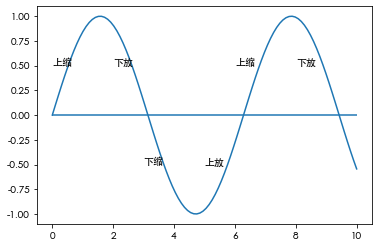

In [51]:
import numpy as np
x = np.linspace(0,10,100)
y = np.sin(x)
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rc("font",family='Heiti TC')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.plot(x,y)
plt.hlines(0,0,10)
plt.text(0,0.5,"上缩")
plt.text(2,0.5,"下放")
plt.text(3,-0.5,"下缩")
plt.text(5,-0.5,"上放")
plt.text(6,0.5,"上缩")
plt.text(8,0.5,"下放")

In [ ]:
np.linspace(0,10,10)